[735. 484.]
486.0
[735. 485.]
486.0


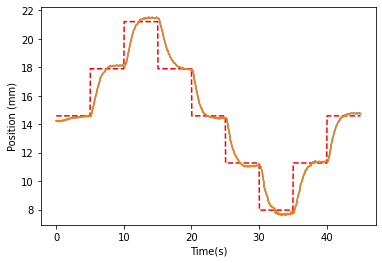

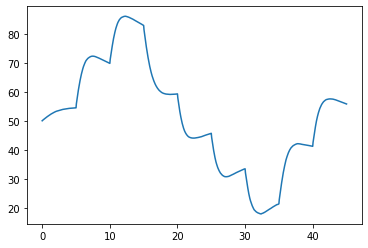

[50.         50.14211631 50.2389231  50.34307328 50.42985095 50.52164319
 50.61343543 50.70522766 50.78466196 50.86911082]


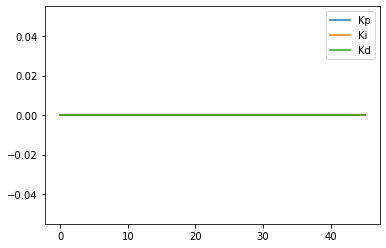

In [1]:
import gym
import numpy as np
from utils import plot_learning_curve
import tensorflow as tf
from MY_PID import PID
import matplotlib.pyplot as plt
import time
import torch as T
import torch.nn as nn

###### SEPARATE ENVIRONMENTS FOR DIFFERENT STATE INFERENCE METHODS. (CHOOSE ONE) ###########

#import MFC_aileron_env_discrete_pytorch_variable_target_LSTM_flex_to_laz_PID_10obs_CONNECTED as mfc_env
#import MFC_aileron_env_discrete_pytorch_variable_target_simple_flex_to_laz_PID_10obs_CONNECTED as mfc_env
import MFC_aileron_env_discrete_pytorch_variable_target_laz_PID_10obs_CONNECTED as mfc_env


def set_volt_bias(goal, init_bias):
    if goal>0:
        out = init_bias #+goal*33
    else:
        out = init_bias #+goal*33
    return out
env = mfc_env.MFC_aileron_Env()
#env = mfc_env.MFC_aileron_Env(qc=5000, R=0.00001)
N = 20
batch_size = 64
n_epochs = 4
dwait = 0.01
delt = 0.05
last_dt = 0.05

alpha = 0.0000025
beta = 0.000025
tau=0.001
gamma = 0.99
goals = [0, 0.5, 1, 0.5,0, -0.5,-1,-0.5, 0]
goal_len = len(goals)
steps_per_test_ep = 100
#states = np.zeros((steps_per_test_ep, 4))
states = np.zeros((steps_per_test_ep*goal_len+1, 4))
lazer_obs = np.zeros(steps_per_test_ep*goal_len+1)


Kp_base = 2.4377 #0.5 #1.97 #2.4377
Ki_base = 1/0.4743#1/0.3743 #1/0.3 #0 #0.03743
Kd_base = 0.1186# 0.075 #0.0936
Kw_base = 0#Ki_base #np.sqrt(Ki_base*Kd_base)

pid = PID(Kp_base, Ki_base, Kd_base, Kw_base, goal_position=0)
#pid = PID(Kp_base, Ki_base, Kd_base, goal_position=0)

all_gains = np.zeros((steps_per_test_ep*goal_len+1, 3))
time.sleep(1)
timesteps = [0]
#observation, lazer_obs[0], _ = env.reset()
observation, lazer_obs[0] = env.reset()
observation = observation[:,-1]
states[0,:] = observation
last_dt = 0.05
init_v_bias = 50 #100
for ii, g in enumerate(goals):
    env.next_goal(g)
    pid.change_goal(g)

    for i in range(steps_per_test_ep):
    
        #For using Lazer information instead of flex
        #observation[0] = (lazer_obs[ii*steps_per_test_ep+i]-497.5)/226
        
        v_bias = set_volt_bias(g, init_v_bias)
        action, _ = pid.output(observation[0], dt=last_dt, interact=True)
        action = action 
         
        #observation_, dt, done, lazer_obs[ii*steps_per_test_ep+i+1], _ = env.step(action)
        observation_, dt, done, lazer_obs[ii*steps_per_test_ep+i+1] = env.step(action)
        observation_ = observation_[:,-1]
        timesteps=np.append(timesteps, timesteps[ii*steps_per_test_ep+i]+dt)
        error = (observation[0]-observation[-1])
        reward = -(error*error)
        observation = observation_
        #states[i,:] = observation
        #print(observation)
        states[ii*steps_per_test_ep+i+1,:] = observation
        init_v_bias = action
    
env.end()
            
plt.plot(timesteps, (states[:,0]*226+497.5)*30/1023)
plt.plot(timesteps, (states[:,3]*226+497.5)*30/1023, '--r')
plt.plot(timesteps, (lazer_obs)*30/1023, label='lazer')
plt.xlabel('Time(s)')
plt.ylabel('Position (mm)')
plt.show()
plt.plot(timesteps, states[:,2]*26.8+50)
plt.show()
print(states[:10, 2]*26.8+50)
plt.plot(timesteps, all_gains[:,0], label='Kp')
plt.plot(timesteps, all_gains[:,1], label='Ki')
plt.plot(timesteps, all_gains[:,2], label='Kd')
plt.legend()

plt.show()

In [2]:
env.ser.close()

### 